### This file contains Linear programing randomize alg. and relaed test results.

_________

### Contents
*  I. read from outfile the ramdomly generated test data 
* II. Helper functions
* III. Main function
* IV. Test & plots
* V. Greedy cover alg.

In [10]:
import pandas as pd
import numpy as np
import os 
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import time
from pulp import *
import random as rd
import math
import random as rd

##  I. read from outfile the ramdomly generated test data (100 tasks, 400 people)

In [3]:
with open ('outfile', 'rb') as fp:
    itemlist = pickle.load(fp)
task = itemlist[0]
people = itemlist[1]

## II. Helper functions 
* constraints are ramdomly generated, with alpha being the percentage of constraints-involved tasks

In [474]:
# cross products
def cross(a,b):
    p = 0
    for (x,y) in zip(a,b):
        p+=(x*y)
    return p

# fomalize outputs
def output(arr):
    new = np.zeros((len(arr),len(arr[0])))
    for i in range(len(new)):
        for j in range(len(new[0])):
            new[i][j] = value(arr[i][j])
    return new

# print constraints
def printCons(prob):
    for a in prob.constraints.values():
        print(a)

# add additional constrain to lp problem: 
# person p can be only assigned to team j
def prerequsite(p,j,prob,X): 
    prob += X[p][j] == 1
    prob += sum(X[p]) == 1

# create superset of constrants for later use; return[[p1,p2...],task_index] pairs
def generate_constraints(J,P,alpha):
    pairs = []
    chosen_to_be_fixed = []
    for i in np.random.choice(len(J),round(len(J)*alpha),replace=False):
        temp = [] 
        pre_size = np.random.choice(3) + 2 # decide the size of the already fixed group
        for j in range(pre_size): # find people fill in 
            for k in range(len(P)):
                if (k not in chosen_to_be_fixed) and \
                (sum([(x+y) == 2 for (x,y) in zip(P[k],J[i])])>0): # have to have some overlap
                    chosen_to_be_fixed.append(k)
                    temp.append(k)
                    break
        pairs.append([temp,i])
    return pairs

# seclect a percentage of constraints from the superset; return[p,team_index] pairs
def choose_constraints(J,P,alpha,cons):
    pairs = []
    chosen = []
    for i in range(round(len(J)*alpha)):
#         print(cons[i])
        task_index = cons[i][1]
        for member in cons[i][0]:
            chosen.append(member)
            pairs.append([member,task_index])
    return pairs

## III. Main function 

In [498]:
def LPRD(J,P,R,pairs):
    """
    minimize personal loads with must-link constraints.

    Args:
        J: An array with shape (n_tasks,n_features) containing info about tasks
        P: An array with shape (n_people,n_features) containing info about people
        pairs: A array with shape (n_pairs,2) containing info of the constraints, ex.[[person_index,task_index],...] 
        R: Number of iterations in the randomize part
        
    Returns:
        A binary matrix X with shape (n_people, n_tasks), indicating the assignments.
        
    Raises:

    """
    X = [[0 for x in range(len(J))] for y in range(len(P))]  # assignment matrix
    ##_____________________________________________-
    # declare your variables
    L = LpVariable("L", 0, 1000)
    namestr = 0 
    for i in range(len(X)):
        for j in range(len(X[1])):
            X[i][j] = LpVariable('x'+ str(namestr), 0, 1) # 0=<x<=1
            namestr += 1

    # defines the problem
    prob = LpProblem("problem", LpMinimize)
    # defines the objective function to minimize
    prob += L
    
    
    ##_____________________________________________-
    ## additional constraints!!!!

    chosen = [x[0] for x in pairs]
    for pair in pairs:
#         print(pair)
        prerequsite(pair[0],pair[1],prob,X)
    
    print("# constraints:", len(pairs))
    
    # find able-cover
    able_cover = [0]*len(P[0])
    for i in range(len(P)):
        able_cover = [x or y for (x,y) in zip(P[i],able_cover)]
    print("able to cover:",sum(able_cover))
    able_cover = [0]*len(P[0])
    for i in range(len(P)):
        if i not in chosen:
            able_cover = [x or y for (x,y) in zip(P[i],able_cover)]    
    print("able to cover without pre-fixed cover:",sum(able_cover))
    
    # find needed-cover
    Jtemp = J[:]
    needed_cover = [0]*len(P[0])
    for i in range(len(Jtemp)):
        needed_cover = [x or y for (x,y) in zip(Jtemp[i], needed_cover)]
    print("need cover:",sum(needed_cover),len(needed_cover))
    
    for pair in pairs:
        Jtemp[pair[1]]  = [max(x-y,0) for (x,y) in zip(Jtemp[pair[1]], P[pair[0]])]    

    needed_cover = [0]*len(P[0])
    for i in range(len(Jtemp)):
        needed_cover = [x or y for (x,y) in zip(Jtemp[i], needed_cover)]
    print("need cover besides pre-fixed cover:",sum(needed_cover),len(needed_cover))
    
    needed_delete = [x>y for (x,y) in zip(needed_cover,able_cover)]
    print("cannot cover after constraint:", sum(needed_delete))
    needed_delete_mutiplicity = \
            [sum([1 for x in J if x[i]==1]) for i in range(len(needed_delete)) if needed_delete[i]==True]
    print("cannot cover(multiplicity) after constraint:", sum(needed_delete_mutiplicity))

    ##______________________________________________
    # defines the regular constraints

    for i in range(len(X)):  # all people's loads subject to a uppper bound 
        prob += sum(X[i])<=L

    for i in range(len(J)): # all skills in all tasks must be covered 
        for j in range(len(J[0])):
            if needed_delete[j] == 0:
                prob += cross([a[i] for a in X],[a[j] for a in P]) >= J[i][j]    
    ##_____________________________________________
    # solve the problem
    status = prob.solve(GLPK(msg=0))
    print(LpStatus[status])
    
    ##_____________________________________________-
    # print output 
    print("L:",value(L))

    ##_____________________________________________-
    #randomize process
    X = output(X)
    for i in range(len(X)):
        for j in range(len(X[0])):
            for k in range(R):
                if rd.uniform(0,1)<X[i][j]: # if at least one time it's chosen
                    X[i][j] = 1 
                    break
                if k == R-1: 
                    X[i][j] = 0 # if not chosen in any round

    print("L:", max([sum(a) for a in X]))
#     print("X:", X)
    return [value(L),max([sum(a) for a in X]),sum(needed_delete),sum(needed_delete_mutiplicity)]

## IV. Test 

In [477]:
# generate a superset of constraint, with 30 tasks as input
all_cons = generate_constraints(task[:30],people,1)
print(len(all_cons))

100


In [ ]:
# simple test
t0 = time.time()
constraints = choose_constraints(task[:30],people,0.9,all_cons)
sol = LPRD(task[:30],people,10,constraints)
print(time.time()-t0)

In [559]:
# generate a superset of constraint
all_cons = generate_constraints(task[:],people,1)
print(len(all_cons))
# save constraints
with open('all_cons', 'wb') as fp:
    pickle.dump(all_cons, fp)

In [482]:
# test change alpha:
temp = []
for i in range(10):
    t0 = time.time()
    constraints = choose_constraints(task[:],people,i/10,all_cons)
    sol = LPRD(task[:],people[:],10,constraints)
    print(time.time()-t0)
    temp.append(sol)

# constraints: 0
able to cover: 225
able to cover without pre-fixed cover: 225
need cover: 109 329
need cover besides pre-fixed cover: 109 329
cannot cover after constraint 0
cannot cover(multiplicity) after constraint 0
Optimal
L: 4.0
L: 4.0
255.85549402236938
# constraints: 27
able to cover: 225
able to cover without pre-fixed cover: 220
need cover: 109 329
need cover besides pre-fixed cover: 109 329
cannot cover after constraint 1
cannot cover(multiplicity) after constraint 1
Optimal
L: 4.0
L: 4.0
253.5968849658966
# constraints: 54
able to cover: 225
able to cover without pre-fixed cover: 215
need cover: 109 329
need cover besides pre-fixed cover: 106 329
cannot cover after constraint 3
cannot cover(multiplicity) after constraint 5
Optimal
L: 4.0
L: 4.0
244.39181399345398
# constraints: 84
able to cover: 225
able to cover without pre-fixed cover: 209
need cover: 109 329
need cover besides pre-fixed cover: 106 329
cannot cover after constraint 4
cannot cover(multiplicity) after cons

In [519]:
# save LPRD output
with open('LRPD', 'wb') as fp:
    pickle.dump(temp, fp)

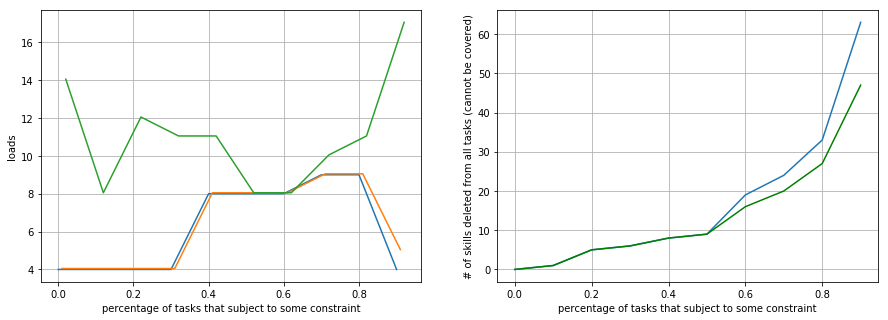

In [568]:
# plot results
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot([x/10 for x in range(10)], [x[0] for x in temp] )
plt.plot([x/10+0.01 for x in range(10)], [x[1]+0.05 for x in temp])
plt.plot([x/10+0.02 for x in range(10)], [x[0]+0.05 for x in greedy_results] )

plt.ylabel('loads')
plt.xlabel('percentage of tasks that subject to some constraint')
plt.grid()

plt.subplot(1,2,2)
plt.plot([x/10 for x in range(10)], [x[3] for x in temp] )
# plt.plot([x/10 for x in range(10)], [x[2] for x in temp] )
plt.plot([x/10 for x in range(10)], [x[1] for x in greedy_results],c='green' )

plt.ylabel('# of skills deleted from all tasks (cannot be covered)')
plt.xlabel('percentage of tasks that subject to some constraint')
plt.grid()
plt.show()

_______________

## V. Greedy Cover

In [555]:
# greedy cover for tasks one by one
def greedy_cover(J,P,pairs): 
    tasks, free = initiate(J,P,pairs)
    cover = [0]*len(P)
    cannot_cover = 0
    assignment = []
    for i in range(len(tasks)):
        task = tasks[i]
        team = []
        while sum(task)>0: 
            temp = 0
            best = 0
            for k in range(len(P)):
                if free[k] and k not in team:
                    able_cover = sum([x+y ==2 for (x,y) in zip(P[k],task)])
                    if able_cover > temp:
                        temp = able_cover
                        best = k
            if temp == 0: 
                cannot_cover += sum(task)
                assignment.append(team)
                break
#             print(team,temp,best,sum(task))
            cover[best] += 1
            team.append(best)
            task = [max(0,y-x) for (x,y) in zip(P[best],task)]
        assignment.append(team)
    return max(cover),cannot_cover,assignment

# pre-process tasks & people
def initiate(J,P,pairs):
    tasks = J[:]
    free = [True] * len(P)
    for [x,y] in pairs:
#         print(x,y)
        tasks[y] = [max(a-b,0) for (a,b) in zip(tasks[y],P[x])]
        free[x] = False
    return tasks,free


In [556]:
# test
greedy_results = []
for i in range(10):
    t0 = time.time()
    constraints = choose_constraints(task[:],people,i/10,all_cons)
    a,b,c = greedy_cover(task[:],people[:],constraints)
    print(time.time()-t0)
    greedy_results.append([a,b,c])

2.9945781230926514
2.750607967376709
2.4696898460388184
2.2583701610565186
2.0872280597686768
1.8298351764678955
1.6376171112060547
1.4072449207305908
1.2246079444885254
0.9304728507995605


_________________